In [303]:
from bs4 import BeautifulSoup as BS
from mpl_toolkits.basemap import Basemap
from shapely.geometry import Point
from IPython.display import display, clear_output

import urllib.request
import pandas as pd
import numpy as np
import re as r
import matplotlib.pyplot as plt
import ipywidgets as widgets

%matplotlib inline

#### Define url as data frame and read in

In [246]:
request = urllib.request.Request('https://en.wikipedia.org/wiki/List_of_deadly_earthquakes_since_1900')
result = urllib.request.urlopen(request)
resulttext = result.read()

#### Use BS constructor to pull data from HTML document 

In [247]:
soup = BS(resulttext, 'html.parser')

#### Look at well formed print of your soup

In [248]:
soup.prettify

<bound method Tag.prettify of <!DOCTYPE html>

<html class="client-nojs" dir="ltr" lang="en">
<head>
<meta charset="utf-8"/>
<title>List of deadly earthquakes since 1900 - Wikipedia</title>
<script>document.documentElement.className = document.documentElement.className.replace( /(^|\s)client-nojs(\s|$)/, "$1client-js$2" );</script>
<script>(window.RLQ=window.RLQ||[]).push(function(){mw.config.set({"wgCanonicalNamespace":"","wgCanonicalSpecialPageName":false,"wgNamespaceNumber":0,"wgPageName":"List_of_deadly_earthquakes_since_1900","wgTitle":"List of deadly earthquakes since 1900","wgCurRevisionId":810533305,"wgRevisionId":810533305,"wgArticleId":11673441,"wgIsArticle":true,"wgIsRedirect":false,"wgAction":"view","wgUserName":null,"wgUserGroups":["*"],"wgCategories":["Articles needing additional references from July 2017","All articles needing additional references","Articles needing cleanup from July 2017","All pages needing cleanup","Cleanup tagged articles with a reason field from Jul

#### Find particular elements in the soup 

In [249]:
data = []
table = soup.find('table', "sortable wikitable")


#### Iterate through your table, grab each row, and pull the < th > and < td > elements into a dataset 

In [250]:
table = table.find_all('tr')

In [251]:
for row in table:
    cells = row.find_all('td')
    cells = [ele.text.strip() for ele in cells]
    data.append(cells)

#### Define data frame and its field names and remove and extraneous records

In [252]:
quake_df = pd.DataFrame(data)
quake_df.drop(0, inplace=True)
quake_df = quake_df.rename(columns={0:'Origin', 1:'Country', 2:'Lat', 3:'Long', 4:'Depth', 5:'Magnitude', 6:'Secondary Effects', 7:'PDE_Shaking', 8:'PDE_Total', 9:'Utsu_Total', 10:'EM_DAT_Total', 11: 'Other'})


#### Replace empty strings with NaN 

In [253]:
quake_df = quake_df.apply(lambda x: x.str.strip()).replace('', np.nan)

#### Remove the footnotes from the 'Other Source Deaths' column

In [254]:
quake_df['Other'] = quake_df.Other.str.replace(r'+','')
quake_df['Other'] = quake_df.Other.str.replace(r',','')
quake_df['Other'] = quake_df.Other.str.extract('(\d+)', expand = True)
quake_df['EM_DAT_Total'] = quake_df.EM_DAT_Total.str.extract('(\d+)', expand = True)

#### Remove the footnotes from the 'Country' column

In [255]:
quake_df['Country'] = quake_df.Country.str.replace(r'\(.*','')

#### Convert Magnitude to a numeric

In [256]:
quake_df['Magnitude'] = quake_df.Magnitude.str.extract('(\d\.\d)', expand = True)

#### Clean 'Longitude' column

In [257]:
quake_df['Long'] = quake_df['Long'].str.replace('?', '')
quake_df['Long'] = quake_df['Long'].astype(str)
quake_df['Long'] = quake_df['Long'].apply(lambda x: x.strip()).replace('', np.nan)
quake_df['Long'] = quake_df['Long'].astype(float)

#### Clean 'Latitude' column

In [258]:
quake_df['Lat'] = quake_df['Lat'].astype(str)
quake_df['Lat'] = quake_df['Lat'].str.replace('?', '')
quake_df['Lat'] = quake_df['Lat'].str.replace('?', '')
quake_df['Lat'] = quake_df['Lat'].apply(lambda x: x.strip()).replace('', np.nan)
quake_df['Lat'] = quake_df['Lat'].astype(float)


In [260]:
quake_df[['PDE_Total', 'Utsu_Total', 'EM_DAT_Total', 'Other']] = quake_df[['PDE_Total', 'Utsu_Total', 'EM_DAT_Total', 'Other']].fillna(-1)
quake_df['PDE_Total'] = quake_df['PDE_Total'].astype(float)
quake_df['Utsu_Total'] = quake_df['Utsu_Total'].astype(float)
quake_df['EM_DAT_Total']= quake_df['EM_DAT_Total'].astype(float)
quake_df['Other'] = quake_df['Other'].astype(float)

,Origin,Country,Lat,Long,Depth,Magnitude,Secondary Effects,PDE_Shaking,PDE_Total,Utsu_Total,EM_DAT_Total,Other
1,1900-05-11 17:23,Japan,38.7,141.1,5,7.0,NaN,NaN,-1.0,-1.0,-1.0,-1.0
2,1900-07-12 06:25,Turkey,40.3,43.1,NaN,5.9,NaN,NaN,-1.0,140.0,-1.0,-1.0
3,1900-10-29 09:11,Venezuela,11.0,-66.0,0,7.7,NaN,NaN,-1.0,-1.0,-1.0,-1.0
4,1901-02-15 00:00,China,26.0,100.1,0,6.5,NaN,NaN,-1.0,-1.0,-1.0,-1.0
5,1901-03-31 07:11,Bulgaria,43.4,28.7,NaN,6.4,NaN,NaN,-1.0,4.0,-1.0,-1.0


In [261]:
def max(row):
        if row['Other'] >= row['PDE_Total'] and row['Other'] >= row['Utsu_Total']\
        and row['Other'] >= row['EM_DAT_Total']:
            return row['Other']
    
        elif row['PDE_Total'] >= row['Other'] and row['PDE_Total'] >= row['Utsu_Total']\
        and row['PDE_Total'] >= row['EM_DAT_Total']:
            return row['PDE_Total']

        elif row['Utsu_Total'] >= row['Other'] and row['Utsu_Total'] >= row['PDE_Total']\
        and row['Utsu_Total'] >= row['EM_DAT_Total']:
            return row['Utsu_Total']

        else: 
            return row['EM_DAT_Total']

quake_df['Deaths'] = quake_df[['EM_DAT_Total','Utsu_Total','PDE_Total','Other']].apply(max, axis=1)
quake_df[['EM_DAT_Total','Utsu_Total','PDE_Total','Other', 'Deaths']]=quake_df[['EM_DAT_Total','Utsu_Total','PDE_Total','Other', 'Deaths']].replace(-1.0,np.NaN)


#### Read in file with US lat-long

In [263]:
##US_df = gpd.read_file('Data/USA_adm1.shp')
US_df = pd.read_csv('Data/vs30data_utf8.csv')
geometry = [Point(xy) for xy in zip(US_df.Longitude, US_df.Latitude)]
crs = {'init': 'epsg:4326'}


In [264]:
def soil_category(row):
        if row['Vs30 (m/s)'] > 1500:
            return 'Type A'
        
        elif row['Vs30 (m/s)'] <= 1500 and row['Vs30 (m/s)'] > 760:
            return 'Type B'
        
        elif row['Vs30 (m/s)'] <= 760 and row['Vs30 (m/s)'] > 360:
            return 'Type C'
        
        elif row['Vs30 (m/s)'] <= 360 and row['Vs30 (m/s)'] > 180:
            return 'Type D'
        
        elif row['Vs30 (m/s)'] < 180:
            return 'Type E'
        
        else:
            return 'No Category'
    
US_df['SoilProfileType'] = US_df.apply(soil_category, axis= 1)

US_df.crs = {'init': 'epsg:4326'}

#### Define soil data for California Longitudes and Latitudes  

In [265]:
Cal_Soil = US_df.query("34.3<Latitude<40.5")
Cal_Soil = Cal_Soil.query("-122.4<Longitude<-116.9")

#### Define earthquake data for California Longitudes and Latitudes  

In [267]:
Cal_quake_df = quake_df.query("34.3<Lat<40.5")
Cal_quake_df = Cal_quake_df.query("-122.4<Long<-116.9")

#### Define Califonia depth data to be used for bubble chart

In [312]:
Depth = Cal_quake_df['Depth'].astype(list)
Depth = Depth.fillna(0)
Depth = Depth.astype(float)
Depth.dtypes

dtype('float64')

#### Define Califonia magnitude data to be used for bubble chart

In [313]:
Magnitude = Cal_quake_df['Magnitude'].astype(list)
Magnitude = Magnitude.fillna(0)
Magnitude = Magnitude.astype(float)
Magnitude.dtypes

dtype('float64')

#### Define Califonia Deaths data to be used for bubble chart

In [314]:
Deaths = Cal_quake_df['Deaths'].astype(list)
Deaths = Deaths.fillna(0)
Deaths = Deaths.astype(float)
Deaths.dtypes

dtype('float64')

#### Read in California shape file 

In [266]:
cal = gpd.read_file('Data\California County Shape Files\County\CaliforniaCounty.shp')
cal.crs = {'init': 'epsg:4326'}

In [ ]:
Cal_quake = Cal_quake.fillna(0)
Cal_quake = Cal_quake.astype(float)
Cal_quake.dtypes

In [294]:
variables = ["Depth", "Magnitude", "Deaths"]
variables.insert(0, 'Select a variable')

130     6.2
329     7.3
331     5.8
506     6.7
654     5.8
848     5.4
851     6.9
1205    6.6
Name: Magnitude, dtype: float64


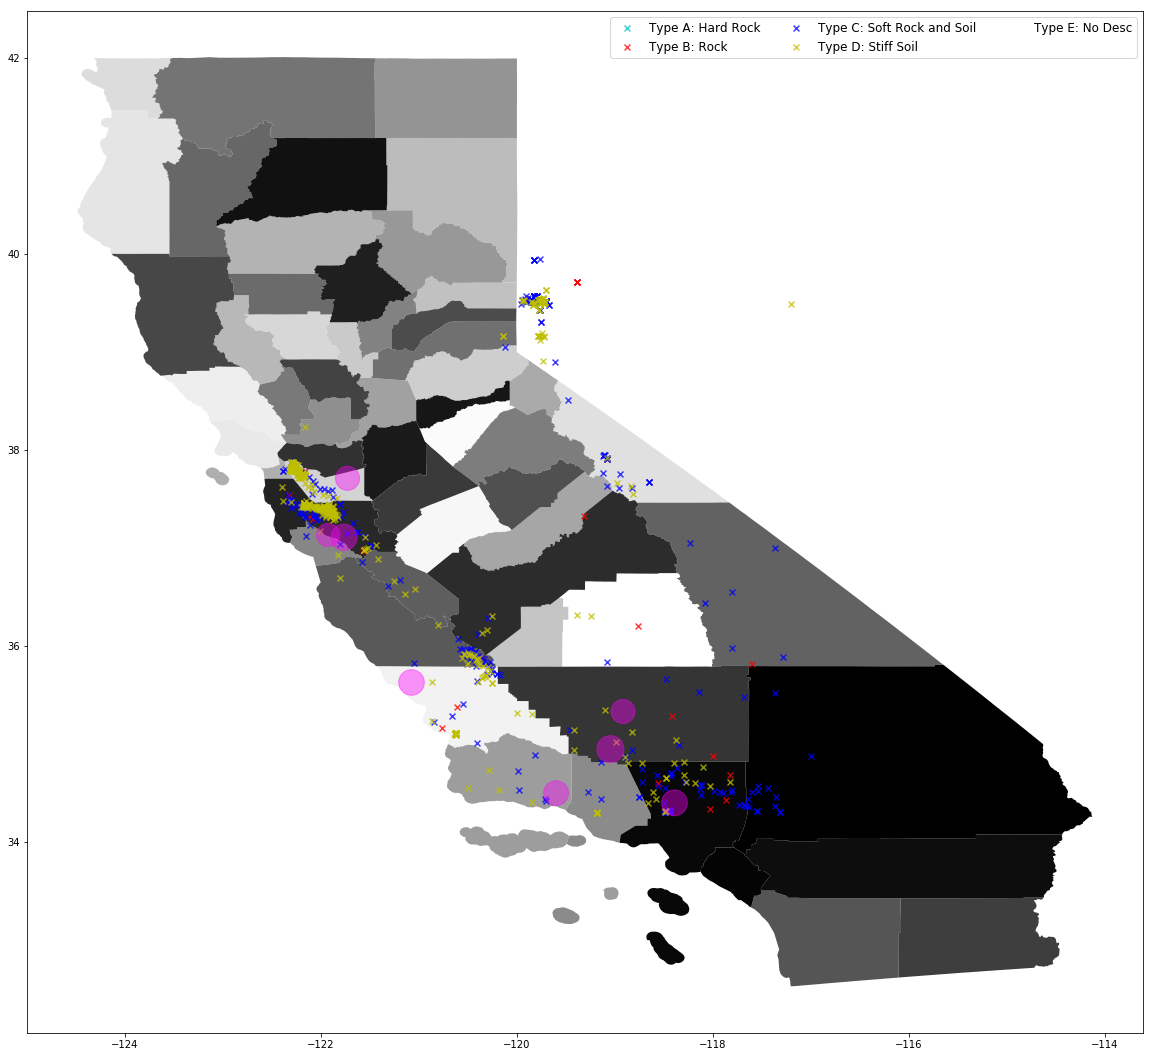

In [321]:
variable_dropdown = widgets.Dropdown(
    options=variables,
    value='Select a variable', 
    description='Variable:',
    disabled=False,
)

#define the behavior you want when a widget event is triggered (handler)
def response(change):
    clear_output()
    fig, ax = plt.subplots(figsize = (20, 20), subplot_kw = {'aspect': 'equal'})

    cal.plot(ax=ax, cmap = 'binary')

    A = plt.scatter(data = Cal_Soil.query('SoilProfileType == "Type A"'), x = 'Longitude', y = 'Latitude', 
                marker = 'x', s=35, alpha = 0.75, color = 'c')

    B = plt.scatter(data = Cal_Soil.query('SoilProfileType == "Type B"'), x = 'Longitude', y = 'Latitude', 
        marker = 'x', s=35, alpha = 0.75, color = 'r')

    C = plt.scatter(data = Cal_Soil.query('SoilProfileType == "Type C"'), x = 'Longitude', y = 'Latitude', 
        marker = 'x', s=35, alpha = 0.75, color = 'b')

    D = plt.scatter(data = Cal_Soil.query('SoilProfileType == "Type D"'), x = 'Longitude', y = 'Latitude', 
        marker = 'x', s=35, alpha = 0.75, color = 'y')

    E = plt.scatter(data = Cal_Soil.query('SoilProfileType == "Type E"'), x = 'Longitude', y = 'Latitude', 
        marker = 'x', s=35, alpha = 0.75, color = '')

    data = Cal_quake_df[''+change['new']+'']
    
    data = data.astype(list)
    data = data.fillna(0)
    data = data.astype(float)
    
    print(data)
    
    plt.scatter(Cal_quake_df['Long'], Cal_quake_df['Lat'],\
           s=data*100, c = "magenta",alpha=0.4)

    '''plt.scatter(Cal_quake_df['Long'], Cal_quake_df['Lat'],\
           s=Cal_quake_dt*100, c = "white",alpha=0.4)

    plt.scatter(Cal_quake_df['Long'], Cal_quake_df['Lat'],\
           s=Cal_quake_depth*100, c = "green",alpha=0.4)'''

    plt.legend((A, B, C, D, E),
           ('Type A: Hard Rock', 'Type B: Rock', 'Type C: Soft Rock and Soil', 'Type D: Stiff Soil', 'Type E: No Desc'),
           scatterpoints=1,
           loc='upper right',
           ncol=3,
           fontsize=12)

plt.show()

#specify the event trigger
variable_dropdown.observe(response, names='value')

#display widget
display(variable_dropdown)





In [186]:
Cal_quake_df.shape

(8, 13)

In [198]:
aa = np.arange(0,50, 8)
ss = [0, 10, 16, 6.4, 15, 15, 16, 16]


In [207]:
Cal_quake = Cal_quake_df['Depth'].astype(list)


In [217]:
Cal_quake = Cal_quake.fillna(0)
Cal_quake = Cal_quake.astype(float)
Cal_quake.dtypes

dtype('float64')

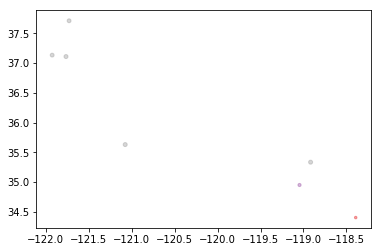

In [218]:
plt.scatter(Cal_quake_df['Long'], Cal_quake_df['Lat'],\
            s=Cal_quake, alpha=0.4, c=Cal_quake_df['Depth'], cmap="Set1")
